# Finde ein effizientes Programm um eine Floyd Rose Gitarre zu stimmen

## Einleitung

Floyd Rose Gitarren sind eine spezielle Art von E-Gitarren, die eine spezielle Art von Brücke verwenden, die als Floyd Rose Tremolo bekannt ist. Diese Brücke ermöglicht es dem Gitarristen, die Tonhöhe der Saiten zu ändern, indem er einen Hebel betätigt, der an der Brücke befestigt ist. Dies ermöglicht es dem Gitarristen, spezielle Effekte wie Vibrato und Divebombs zu erzeugen. Es erschwert jedoch auch das Stimmen der Gitarre erheblich, da bei dem Stimmen einer Saite die anderen Saiten ebenfalls verstimmt werden können, da die Spannung der Saiten auf der Brücke verteilt ist. Ein Grund dafür ist das die Saiten an Federn aufgehängt sind. Dies kann dazu führen, dass das Stimmen einer Floyd Rose Gitarre sehr zeitaufwändig ist.

In dieser Arbeit stellen wir zunächst ein Experiment auf, welches uns informationen über das Verhalten der Saiten gibt, wenn wir eine Saite stimmen. Mit diesen Informationen leiten wir ein mathematisches Modell ab, welches uns erlaubt, die Saiten einer Floyd Rose Gitarre effizient zu stimmen. Es soll berechnet werden welche Saiten in welcher Reihenfolge zu welcher Frequenz gestimmt werden müssen, um die Gitarre möglichst schnell und genau zu stimmen.

Auf dem Weg zu diesem Ziel werden wir ein Programm erstellen, welches uns erlaubt die Frequenz von Saiten zu messen. Die Messdaten von dem Experiment werden Visualisiert und anhand dessen wird das mathematische Modell erstellt.

Anschließend wird ein Program erstellt welches berechnet, welche Saiten in welcher Reihenfolge zu welcher Frequenz gestimmt werden müssen, um die Gitarre möglichst schnell und genau zu stimmen.

Die Arbeit wird in folgende Schritte unterteilt:
1. Experiment
2. Visualisierung
3. Mathematisches Modell
4. Programmierung
5. Testen
6. Optimierung
7. Dokumentation
8. Präsentation

## Experiment

Um die Saiten einer Floyd Rose Gitarre effizient zu stimmen, müssen wir zunächst ein Experiment durchführen, welches uns Informationen über das Verhalten der Saiten gibt, wenn wir eine Saite stimmen.

Dazu wird zunächst jede Saite in eine Ausgangsposition gebracht. Eine Standard Gitarren Stimmung ist EADGBE. Die Saiten werden so gestimmt, dass sie die Frequenzen E2, A2, D3, G3, B3 und E4 haben. Es handelt sich hierbei umd die gleich temperierte Stimmung.
Die Saiten werden demnach die Frequenzen haben:
E2 = 82.41 Hz
A2 = 110.00 Hz
D3 = 146.83 Hz
G3 = 196.00 Hz
B3 = 246.94 Hz
E4 = 329.63 Hz

Dann wird jede Saite um ein Bestimmtes delta verstimmt. Das Delta wird so gewählt, dass die Frequenz der Saite um 1 Hz erhöht wird. Die Frequenz der Saiten wird gemessen und aufgezeichnet.

delta = 1 Hz

Jede Saite wird um 10 delta Schritte jeweils nach oben und nach unten verstimmt. Für jeden Schritt wird die Frequenz der anderen Saiten gemessen und aufgezeichnet.

Schritte in beide Richtungen = 10

Das Ziel des Experiments ist zu beobachten ob das System
- linear ist
- elastisch ist

Die erkenntnisse bestimmen später das mathematische Modell.

### Materialien
- Floyd Rose Gitarre
- Frequenz Messgerät
- Visualisierungssoftware

Die Floyd Rose Gitarre ist verfügbar. Das Frequenz Messgerät wird ein Python Programm sein, welches die Frequenz der Saiten misst. Die Visualisierungssoftware wird ebenfalls ein Python Programm sein, welches die Messdaten visualisiert.

#### Frequenz Messgerät

Gegeben sei eine Liste von Samples. Diese Liste wird mit Hilfe der Fourier Transformation in den Frequenzbereich transformiert. Die Frequenz mit der höchsten Amplitude wird als die Frequenz der Saite angenommen.


In [ ]:
import random


def get_samples():
    # Input from audio device or file
    return [1,2,3,4,5,6,7,8,9,10]

def fourier_transform(samples):
    # Fourier Transformation
    return [1,2,3,4,5,6,7,8,9,10]

def get_peak_frequency(frequencies):
    # Get peak frequency
    return 1

def get_tone_from_samples(samples):
    frequencies = fourier_transform(samples)
    return get_peak_frequency(frequencies)



#### Visualisierungssoftware

Mit hilfe von matplotlib wird eine Visualisierung erstellt. Die Visualisierung zeigt die Frequenz der Saiten in Abhängigkeit von der Verstimmung.
##### Die Daten


ValueError: <Axes: > cannot be transformed to a widget

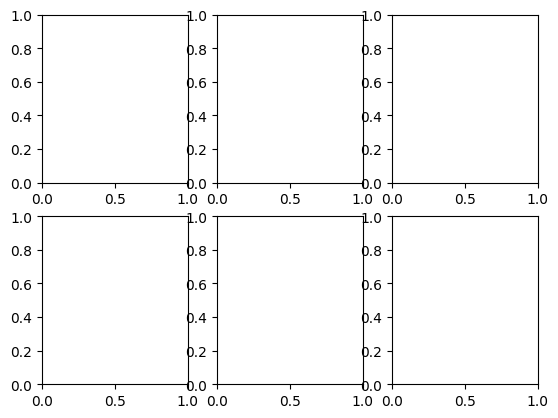

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import random
nStrings = 6
steps = 10
step_range = range(-steps, steps+1) # -10 bis 10
strings = ["E2", "A2", "D3", "G3", "B3", "E4"]
# Verstimmung jeder anderen seite für jede Saite für alle Verstimmungsschritte
example_dataset = {
    string: {other_string: np.array([ -_*random.random() for _ in step_range]) for other_string in strings if other_string != string}
    for string in strings
}

"""
example_dataset = {
    'E2': {
        'A2': array([records_per_step,...]),
        'D3': array([records_per_step,...]),
        ...,
        'E4': array([records_per_step,...])
    },
    'A2': {
        'E2': array([records_per_step,...]),
        'D3': array([records_per_step,...]),
        ...,
        'E4': array([records_per_step,...])
    },
    ...
    'E4': {
        'E2': array([records_per_step,...]),
        'A2': array([records_per_step,...]),
        ...,
        'B3': array([records_per_step,...])
    }
"""

def visualisation(df,string,_plt,**args):
    for other_string in strings:
        if other_string in args.keys() and args[other_string]:
            _plt.plot(step_range, df[string][other_string], label=other_string)
    _plt.title("Impact on String when detuning String "+string)
    _plt.xlabel(f"Detuning of String {string} in Hz")
    _plt.ylabel(f"Frequency of other Strings in Hz")
    _plt.legend()
    _plt.show()

def visualize_all(data):
    fig , plots = plt.subplots(2,3)
    plots_list = [plots[i//3][i%3] for i in range(6)]

    i = 0
    for string in strings:
        activatables = {other_string: True for other_string in strings if other_string != string}
        widgets.interact(visualisation,df=data,string=string,_plt=plots_list[i], **activatables)
        i+=1
        #widget_collection.append(w)

visualize_all(example_dataset)


## Literatur
Gleich temperierte Stimmung: https://de.wikipedia.org/wiki/Gleichstufige_Stimmung
